In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

### Constants

In [2]:
N_FOLDS = 10
SEED = 999

dataset_path = '../input/petfinder-pawpularity-score/'

In [3]:
train_df = pd.read_csv(dataset_path + 'train.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,723a21d091e9f5c50f6399ebbd15415e,0,1,1,1,0,0,0,0,0,0,0,0,27
1,2d126a54855409d7b147e5d570f28f1c,0,0,0,0,0,0,1,0,0,0,0,0,26
2,3557b34de33d07a365e729dcad58d744,1,1,1,1,0,0,0,0,0,0,0,0,72
3,3a66d46585bdfb277e7b41ba9fe07c97,0,1,1,1,0,0,0,0,1,0,0,0,18
4,804a36e8abe417625194b7a37e2b33c7,0,1,1,1,0,1,0,0,0,0,0,0,32


9912 images
Mean: 38.03904358353511
Median: 33.0
Standard deviation: 20.591990105774514


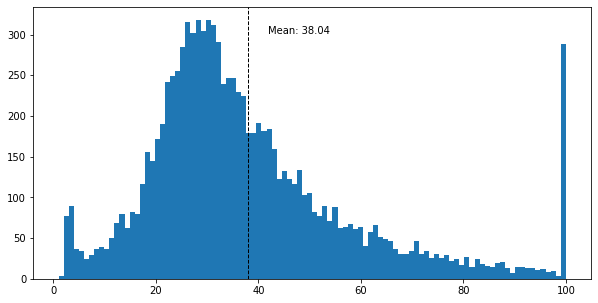

In [4]:
print(f"{len(train_df)} images")
train_df['Pawpularity'].hist(figsize = (10, 5), bins=100, grid=False)
plt.axvline(train_df['Pawpularity'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(train_df['Pawpularity'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(train_df['Pawpularity'].mean()))
print(f"Mean: {train_df['Pawpularity'].mean()}")
print(f"Median: {train_df['Pawpularity'].median()}")
print(f"Standard deviation: {train_df['Pawpularity'].std()}")

In [5]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.27
1       0.26
2       0.72
3       0.18
4       0.32
        ... 
9907    0.14
9908    0.71
9909    0.32
9910    0.46
9911    0.40
Name: norm_score, Length: 9912, dtype: float64

In [6]:
#Sturges' rule
num_bins = int(np.floor(1+np.log2(len(train_df))))

<AxesSubplot:>

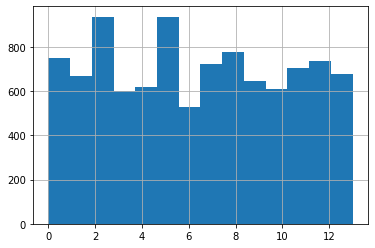

In [7]:
q = pd.qcut(train_df['norm_score'], num_bins, retbins=True, labels=False)
bin_limits = q[1]
train_df['bins'] = q[0]
train_df['bins'].hist(bins=num_bins)

In [8]:
train_df['fold'] = -1

skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

for i, (_, val_index) in enumerate(skf.split(train_df.index, train_df['bins'])):
    train_df.iloc[val_index, -1] = i

In [9]:
test_df = pd.read_csv(dataset_path + 'test.csv')
test_df['Pawpularity'] = [1]*len(test_df)
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [10]:
train_metadata_path = dataset_path + 'train.csv'
test_metadata_path = dataset_path + 'test.csv'

train_metadata = pd.read_csv(train_metadata_path).sort_values(by='Id')

In [11]:
def split_fold(df, fold):
    train = df.loc[df['Id'].isin(train_df[train_df['fold'] != fold]['Id'].values)]
    val = df.loc[df['Id'].isin(train_df[train_df['fold'] == fold]['Id'].values)]
    return train, val

In [12]:
test_metadata = pd.read_csv(test_metadata_path).sort_values(by='Id')
X_test = test_metadata.iloc[:,2:]

In [13]:
pca = PCA(n_components=2)
pca.fit(X_test)
X_test = X_test.join(pd.DataFrame(pca.transform(X_test), index=X_test.index).add_prefix('pca_'))

In [14]:
preds = []
val_preds = []

for i in range(10):
    print(f'XGB - Training fold {i}')

    train, val = split_fold(train_metadata, i)

    y_train_xgb = train['Pawpularity']
    X_train_xgb = train.iloc[:,2:-1]

    y_val_xgb = val['Pawpularity']
    X_val_xgb = val.iloc[:,2:-1]

    pca = PCA(n_components=2)
    pca.fit(X_train_xgb)
    X_train_xgb = X_train_xgb.join(pd.DataFrame(pca.transform(X_train_xgb), index=X_train_xgb.index).add_prefix('pca_'))

    pca = PCA(n_components=2)
    pca.fit(X_val_xgb)
    X_val_xgb = X_val_xgb.join(pd.DataFrame(pca.transform(X_val_xgb), index=X_val_xgb.index).add_prefix('pca_'))

    params = {
        'max_depth': 3,
        'n_estimators': 400,
        'min_child_weight': 2,
        'colsample_bytree': 0.5696,
        'subsample': 0.5389,
        'eta': 0.3116,
        'objective': 'reg:squarederror',
        'seed': SEED
    }

    model = XGBRegressor(**params, n_jobs=-1)

    fit_params = {
        'eval_metric': 'rmse',
        'eval_set': [(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)],
        'early_stopping_rounds': 400,
        'verbose': False
    }

    model.fit(X_train_xgb, y_train_xgb, **fit_params)
    preds.append(model.predict(X_test))
    print(f'RMSE: {np.sqrt(mean_squared_error(model.predict(X_val_xgb), y_val_xgb))}\n')

xgb_preds = np.mean(np.stack(preds), axis=0)

XGB - Training fold 0
RMSE: 20.569260063094397

XGB - Training fold 1
RMSE: 20.80566135458192

XGB - Training fold 2
RMSE: 20.267794880114696

XGB - Training fold 3
RMSE: 20.556720567516408

XGB - Training fold 4
RMSE: 20.821383637080146

XGB - Training fold 5
RMSE: 20.342602933360034

XGB - Training fold 6
RMSE: 20.662200269751658

XGB - Training fold 7
RMSE: 20.81247219934727

XGB - Training fold 8
RMSE: 20.53371885152351

XGB - Training fold 9
RMSE: 20.933207651524043



In [15]:
test_predictions = pd.DataFrame()
test_predictions['Id'] = test_metadata.Id
test_predictions['Pawpularity'] = xgb_preds
test_predictions.to_csv('submission.csv', index=False)
test_predictions.head(8)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,37.474216
1,43a2262d7738e3d420d453815151079e,38.399929
2,4e429cead1848a298432a0acad014c9d,43.118835
3,80bc3ccafcc51b66303c2c263aa38486,36.807972
4,8f49844c382931444e68dffbe20228f4,34.878101
5,b03f7041962238a7c9d6537e22f9b017,41.095741
6,c978013571258ed6d4637f6e8cc9d6a3,36.054890
7,e0de453c1bffc20c22b072b34b54e50f,37.921703
